In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_b25_roi_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 1015)
(734160, 1)
validation
(101248, 1015)
(101248, 1)
test
(100432, 1015)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1015)]            0         


 dense (Dense)               (None, 1024)              1040384   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1729537 (6.60 MB)


Trainable params: 1729537 (6.60 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:52 - loss: 0.0211 - STD: 1.4848e-04 - MAE: 0.1342

 3/74 [>.............................] - ETA: 1s - loss: 0.0220 - STD: 2.1844e-04 - MAE: 0.1144  

 5/74 [=>............................] - ETA: 1s - loss: 0.0200 - STD: 3.3642e-04 - MAE: 0.0998

 7/74 [=>............................] - ETA: 1s - loss: 0.0182 - STD: 5.8415e-04 - MAE: 0.0981

 9/74 [==>...........................] - ETA: 1s - loss: 0.0177 - STD: 8.3198e-04 - MAE: 0.1005

11/74 [===>..........................] - ETA: 1s - loss: 0.0166 - STD: 0.0010 - MAE: 0.0946    

13/74 [====>.........................] - ETA: 1s - loss: 0.0161 - STD: 0.0012 - MAE: 0.0895

15/74 [=====>........................] - ETA: 4s - loss: 0.0159 - STD: 0.0013 - MAE: 0.0859

17/74 [=====>........................] - ETA: 3s - loss: 0.0154 - STD: 0.0015 - MAE: 0.0831

19/74 [======>.......................] - ETA: 3s - loss: 0.0151 - STD: 0.0017 - MAE: 0.0830

21/74 [=======>......................] - ETA: 3s - loss: 0.0149 - STD: 0.0020 - MAE: 0.0836

23/74 [========>.....................] - ETA: 2s - loss: 0.0146 - STD: 0.0022 - MAE: 0.0828

25/74 [=========>....................] - ETA: 2s - loss: 0.0143 - STD: 0.0025 - MAE: 0.0811

27/74 [=========>....................] - ETA: 2s - loss: 0.0141 - STD: 0.0028 - MAE: 0.0794

29/74 [==========>...................] - ETA: 2s - loss: 0.0139 - STD: 0.0031 - MAE: 0.0780

31/74 [===========>..................] - ETA: 2s - loss: 0.0137 - STD: 0.0036 - MAE: 0.0773

33/74 [============>.................] - ETA: 1s - loss: 0.0135 - STD: 0.0041 - MAE: 0.0771

35/74 [=============>................] - ETA: 1s - loss: 0.0133 - STD: 0.0048 - MAE: 0.0766

37/74 [==============>...............] - ETA: 1s - loss: 0.0131 - STD: 0.0055 - MAE: 0.0756

39/74 [==============>...............] - ETA: 1s - loss: 0.0129 - STD: 0.0065 - MAE: 0.0745

41/74 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 0.0076 - MAE: 0.0734

43/74 [================>.............] - ETA: 1s - loss: 0.0124 - STD: 0.0091 - MAE: 0.0726

45/74 [=================>............] - ETA: 1s - loss: 0.0121 - STD: 0.0110 - MAE: 0.0716

47/74 [==================>...........] - ETA: 1s - loss: 0.0118 - STD: 0.0130 - MAE: 0.0705

49/74 [==================>...........] - ETA: 1s - loss: 0.0115 - STD: 0.0154 - MAE: 0.0695

51/74 [===================>..........] - ETA: 0s - loss: 0.0112 - STD: 0.0180 - MAE: 0.0684

53/74 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 0.0207 - MAE: 0.0674

55/74 [=====================>........] - ETA: 0s - loss: 0.0107 - STD: 0.0231 - MAE: 0.0664

57/74 [======================>.......] - ETA: 0s - loss: 0.0104 - STD: 0.0254 - MAE: 0.0654

59/74 [======================>.......] - ETA: 0s - loss: 0.0101 - STD: 0.0276 - MAE: 0.0644

61/74 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 0.0295 - MAE: 0.0635

63/74 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0312 - MAE: 0.0626

65/74 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0331 - MAE: 0.0617

67/74 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0351 - MAE: 0.0609

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0370 - MAE: 0.0601

71/74 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0387 - MAE: 0.0594

73/74 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0404 - MAE: 0.0587

74/74 [==============================] - 5s 46ms/step - loss: 0.0087 - STD: 0.0411 - MAE: 0.0584 - val_loss: 0.0028 - val_STD: 0.0694 - val_MAE: 0.0342


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0920 - MAE: 0.0342

 3/74 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0911 - MAE: 0.0337

 5/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0936 - MAE: 0.0341

 7/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0341

 9/74 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0340

11/74 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0960 - MAE: 0.0340

13/74 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0961 - MAE: 0.0340

15/74 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0340

17/74 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0956 - MAE: 0.0341

19/74 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0341

21/74 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0340

23/74 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0340

26/74 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0340

28/74 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0339

30/74 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0339

32/74 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0339

34/74 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0338

36/74 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0338

38/74 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0337

40/74 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0337

42/74 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0337

44/74 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0336

46/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0336

48/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

50/74 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0335

52/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0335

54/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0334

56/74 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0334

58/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0333

60/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0333

62/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0333

64/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0333

66/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

68/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

70/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

72/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

74/74 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

74/74 [==============================] - 2s 29ms/step - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331 - val_loss: 0.0025 - val_STD: 0.0750 - val_MAE: 0.0326


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0321

 3/74 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0319

 5/74 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0319

 7/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0318

 9/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

11/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0317

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0316

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0315

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0315

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0314

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0313

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0313

33/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0313

35/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0313

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0312

39/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0311

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0309

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0309

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0309

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0308

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0308

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0307

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0307

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0307

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0306

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0306

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0306

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0306

74/74 [==============================] - 2s 29ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0306 - val_loss: 0.0023 - val_STD: 0.0757 - val_MAE: 0.0303


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0294

 3/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0291

 5/74 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

 7/74 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

11/74 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0295

13/74 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

15/74 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

17/74 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

19/74 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0291

21/74 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0291

24/74 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

26/74 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

28/74 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

30/74 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

32/74 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0291

34/74 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0296

36/74 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0297

38/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0299

40/74 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0303

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0305

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0308

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0309

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0309

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0310

52/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0309

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0309

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0309

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0309

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0308

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0307

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0307

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0306

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0306

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0305

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

74/74 [==============================] - 2s 29ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304 - val_loss: 0.0022 - val_STD: 0.0769 - val_MAE: 0.0297


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0279

 3/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.0975 - MAE: 0.0283

 5/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.0979 - MAE: 0.0281

 7/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.0981 - MAE: 0.0282

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.0984 - MAE: 0.0283

11/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.0982 - MAE: 0.0283

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0986 - MAE: 0.0282

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0989 - MAE: 0.0282

17/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0988 - MAE: 0.0282

19/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0990 - MAE: 0.0282

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0282

23/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0282

25/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0282

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0992 - MAE: 0.0282

29/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0282

31/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0281

33/74 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0282

35/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

37/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0282

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

41/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0281

43/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

46/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0282

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0282

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0282

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0282

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0282

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0282

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280

74/74 [==============================] - 2s 29ms/step - loss: 0.0018 - STD: 0.1003 - MAE: 0.0280 - val_loss: 0.0021 - val_STD: 0.0797 - val_MAE: 0.0292


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

 3/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

11/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

15/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

20/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

26/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

28/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

32/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

34/74 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

38/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

44/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

46/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

74/74 [==============================] - 2s 29ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0763 - val_MAE: 0.0289


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0277

 3/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0271

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

11/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0274

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0275

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

17/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

21/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

23/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0275

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

30/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

32/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

34/74 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

42/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

48/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - 2s 29ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277 - val_loss: 0.0021 - val_STD: 0.0768 - val_MAE: 0.0290


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0994 - MAE: 0.0278

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0274

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0275

11/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0275

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

17/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

21/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

23/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

27/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

29/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

31/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

33/74 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

35/74 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

45/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - 2s 30ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0770 - val_MAE: 0.0285


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0267

 5/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

33/74 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

35/74 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

74/74 [==============================] - 2s 29ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0777 - val_MAE: 0.0287


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0271

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

 5/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1000 - MAE: 0.0269

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1001 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0268

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0268

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0267

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0268

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0268

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0275

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

33/74 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

35/74 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

74/74 [==============================] - 2s 29ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274 - val_loss: 0.0020 - val_STD: 0.0754 - val_MAE: 0.0285


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0962 - MAE: 0.0266

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1001 - MAE: 0.0271

 5/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0267

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0266

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0264

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0264

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0264

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0264

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

32/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0265

34/74 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0266

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0267

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

74/74 [==============================] - 2s 29ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0763 - val_MAE: 0.0285


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0975 - MAE: 0.0260

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

 5/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0265

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

35/74 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0266

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

74/74 [==============================] - 2s 29ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267 - val_loss: 0.0021 - val_STD: 0.0760 - val_MAE: 0.0291


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0276

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0276

 5/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0269

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0275

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0270

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

33/74 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

35/74 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

74/74 [==============================] - 2s 29ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0799 - val_MAE: 0.0299


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0263

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0258

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0263

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

23/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

29/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

33/74 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0268

35/74 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0266

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0267

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

74/74 [==============================] - 2s 29ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0784 - val_MAE: 0.0281


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0258

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0259

 8/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0259

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0259

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0259

14/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0259

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0259

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0259

20/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0259

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0259

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

26/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

32/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

34/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263 - val_loss: 0.0020 - val_STD: 0.0771 - val_MAE: 0.0283


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0262

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0263

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0261

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0265

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0263

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0261

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0261

35/74 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0784 - val_MAE: 0.0283


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0259

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0263

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0269

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0269

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

32/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

34/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0260

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261 - val_loss: 0.0025 - val_STD: 0.0840 - val_MAE: 0.0350


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1102 - MAE: 0.0310

 3/74 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0310

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0289

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0279

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

26/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

32/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

34/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0740 - val_MAE: 0.0285


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0958 - MAE: 0.0270

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0260

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0260

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0260

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

35/74 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0806 - val_MAE: 0.0285


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0257

 3/74 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0256

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0256

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0254

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0253

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

29/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

33/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

35/74 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0794 - val_MAE: 0.0284


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0252

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0251

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0252

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1009 - MAE: 0.0254

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0254

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0257

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0261

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0260

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0261

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0263

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0262

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0263

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0262

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0262

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0258

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0258

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

57/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0765 - val_MAE: 0.0277


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0262

 3/74 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0263

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0264

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0261

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

35/74 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0789 - val_MAE: 0.0282


Epoch 23/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0246

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1012 - MAE: 0.0249

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0259

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0265

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

35/74 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0260

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0259

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0258

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0775 - val_MAE: 0.0278


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0247

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0254

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0257

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0255

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0257

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

33/74 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

35/74 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0260

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0759 - val_MAE: 0.0275


Epoch 25/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1012 - MAE: 0.0251

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0254

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0256

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0254

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

29/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

33/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

35/74 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

42/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0256

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0256

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0256

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0254

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0254

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0254 - val_loss: 0.0021 - val_STD: 0.0816 - val_MAE: 0.0321


Epoch 26/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0279

 3/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0282

 5/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0270

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0264

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0262

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0262

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0262

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0260

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0258

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0257

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0257

29/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0257

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0257

33/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0256

35/74 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0257

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0256

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0257

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0257

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

45/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0791 - val_MAE: 0.0282


Epoch 27/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0244

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0248

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1020 - MAE: 0.0247

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1023 - MAE: 0.0248

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0248

11/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0251

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0250

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0250

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0249

29/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0249

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

33/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

35/74 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0249

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

45/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0250

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0250

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0250

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0250

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0250

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0251

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1031 - MAE: 0.0251 - val_loss: 0.0020 - val_STD: 0.0742 - val_MAE: 0.0280


Epoch 28/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0963 - MAE: 0.0268

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0255

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0252

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0251

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0250

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0249

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1023 - MAE: 0.0249

15/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0249

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

20/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

24/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

26/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0260

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0260

32/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

34/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

36/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

42/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255 - val_loss: 0.0021 - val_STD: 0.0726 - val_MAE: 0.0285


Epoch 29/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0961 - MAE: 0.0271

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0259

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0257

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0256

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0255

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0254

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0252

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0251

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0251

29/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0250

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0250

33/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0250

35/74 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0250

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0250

40/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

42/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0249

44/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0249

46/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

48/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0249

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0249

54/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0249

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0251

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0251

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0252

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0252

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0252

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0774 - val_MAE: 0.0276


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0241

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1023 - MAE: 0.0244

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0244

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0244

11/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

15/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

21/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0245

23/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0245

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0245

27/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0245

29/74 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0245

31/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0245

33/74 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0246

36/74 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0246

38/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0248

40/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0248

42/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0248

44/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0247

46/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0247

48/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0247

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0247

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0247

54/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0247

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0247

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0247

60/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0247

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0247

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0247

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0247

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0247

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0247

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0248

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0248

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1031 - MAE: 0.0248 - val_loss: 0.0018 - val_STD: 0.0780 - val_MAE: 0.0276


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1007 - MAE: 0.0238

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0245

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0251

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0256

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0255

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0253

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0252

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0251

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

21/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0249

23/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0250

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

29/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0256

33/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

35/74 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0256

41/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

45/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0256

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

57/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

74/74 [==============================] - 2s 29ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253 - val_loss: 0.0019 - val_STD: 0.0775 - val_MAE: 0.0288


Epoch 32/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0248

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1009 - MAE: 0.0245

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0244

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0244

11/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0244

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0244

15/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0245

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0246

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0246

21/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0247

23/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0248

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0248

27/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0249

29/74 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0249

31/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0249

33/74 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0249

35/74 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

37/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

39/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0248

41/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0247

44/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0247

46/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0247

48/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0246

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0246

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0246

54/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0247

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0247

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0247

60/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0247

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0248

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0248

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1031 - MAE: 0.0248 - val_loss: 0.0019 - val_STD: 0.0799 - val_MAE: 0.0301


Epoch 33/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0252

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1016 - MAE: 0.0249

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0257

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0255

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0256

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

30/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

32/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0256

34/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

36/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0255

38/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

42/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

44/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0253

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0253

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0252

50/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0252

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

60/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0250

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249 - val_loss: 0.0018 - val_STD: 0.0773 - val_MAE: 0.0275


Epoch 34/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1042 - MAE: 0.0246

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1025 - MAE: 0.0243

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1024 - MAE: 0.0242

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1019 - MAE: 0.0243

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1026 - MAE: 0.0246

11/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0247

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1026 - MAE: 0.0246

15/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0248

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0248

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0248

21/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0247

23/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0247

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0246

27/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0246

29/74 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0246

31/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0246

33/74 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0245

35/74 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0245

37/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0245

39/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0245

41/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

43/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

45/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

47/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

49/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

51/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

53/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

55/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0245

57/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

59/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

61/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0244

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0244

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0244

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0244

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1034 - MAE: 0.0244 - val_loss: 0.0018 - val_STD: 0.0777 - val_MAE: 0.0274


Epoch 35/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0242

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0248

 5/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0258

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0263

11/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0261

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0263

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0261

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0260

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0258

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0257

24/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0255

26/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0254

28/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0253

30/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0252

32/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0252

34/74 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0251

36/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0251

38/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0250

40/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

42/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0250

44/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

46/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0249

48/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0249

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0249

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

54/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0248

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

60/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0249

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249 - val_loss: 0.0018 - val_STD: 0.0773 - val_MAE: 0.0280


Epoch 36/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0239

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0243

 5/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0241

 7/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0241

 9/74 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0240

11/74 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1043 - MAE: 0.0240

13/74 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1039 - MAE: 0.0240

15/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1039 - MAE: 0.0240

17/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

19/74 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0240

21/74 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0240

23/74 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0240

25/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0240

27/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0242

29/74 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0242

31/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1038 - MAE: 0.0242

33/74 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1037 - MAE: 0.0243

35/74 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0243

37/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0245

39/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1036 - MAE: 0.0245

41/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0246

43/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0246

45/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0246

47/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0246

49/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0246

51/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0246

53/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0245

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

60/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0246

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0245

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245 - val_loss: 0.0018 - val_STD: 0.0773 - val_MAE: 0.0275


Epoch 37/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0012 - STD: 0.1026 - MAE: 0.0239

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0240

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0242

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1039 - MAE: 0.0246

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0246

11/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0244

15/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0243

18/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1038 - MAE: 0.0244

20/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1036 - MAE: 0.0244

22/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0244

24/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0245

26/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0245

28/74 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0244

30/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0244

32/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0244

34/74 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0243

36/74 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

38/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0243

40/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0243

42/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

44/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0243

46/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

48/74 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

50/74 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

52/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

54/74 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0243

56/74 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0243

58/74 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0242

60/74 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0242

62/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0242

64/74 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0242

66/74 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0242

68/74 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0242

70/74 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0242

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0242

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0242

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1034 - MAE: 0.0242 - val_loss: 0.0018 - val_STD: 0.0769 - val_MAE: 0.0276


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1028 - MAE: 0.0233

 3/74 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0236

 5/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

 7/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

 9/74 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1031 - MAE: 0.0237

11/74 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1031 - MAE: 0.0237

13/74 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0237

15/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1036 - MAE: 0.0243

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0254

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0253

23/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

29/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

33/74 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

35/74 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

74/74 [==============================] - 2s 29ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0288


Epoch 39/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1111 - MAE: 0.0248

 3/74 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0239

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1041 - MAE: 0.0241

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0241

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1043 - MAE: 0.0240

11/74 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

13/74 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1041 - MAE: 0.0240

15/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1039 - MAE: 0.0240

17/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

19/74 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

21/74 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

23/74 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0240

25/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

27/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0240

29/74 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

31/74 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

33/74 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0240

35/74 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0240

37/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0240

39/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0240

41/74 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

43/74 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

45/74 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

47/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

49/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0239

51/74 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

53/74 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

55/74 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

57/74 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

59/74 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

61/74 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

63/74 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

65/74 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

67/74 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

69/74 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

72/74 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

74/74 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

74/74 [==============================] - 2s 29ms/step - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239 - val_loss: 0.0018 - val_STD: 0.0753 - val_MAE: 0.0275


Epoch 40/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0012 - STD: 0.0999 - MAE: 0.0240

 3/74 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1030 - MAE: 0.0238

 5/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0238

 7/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1032 - MAE: 0.0237

 9/74 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0237

11/74 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0238

13/74 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0239

15/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0238

17/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

19/74 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

21/74 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

23/74 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

25/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

27/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0237

29/74 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0237

31/74 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0237

33/74 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0237

35/74 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

37/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

39/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0237

41/74 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

43/74 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

45/74 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0237

47/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

49/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

51/74 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0237

54/74 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

56/74 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0237

58/74 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

60/74 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0237

62/74 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

64/74 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0238

66/74 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0239

68/74 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

70/74 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

72/74 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0239

74/74 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

74/74 [==============================] - 2s 29ms/step - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0289


Epoch 41/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

 3/74 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1047 - MAE: 0.0236

 5/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1043 - MAE: 0.0235

 7/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0236

 9/74 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0236

11/74 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0237

13/74 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0237

15/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0237

17/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

19/74 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0238

22/74 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

24/74 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0238

26/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0238

28/74 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

30/74 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

32/74 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

34/74 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0239

36/74 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1033 - MAE: 0.0239

38/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

40/74 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

42/74 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

44/74 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

46/74 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

48/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

50/74 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

52/74 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

54/74 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

56/74 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

58/74 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

60/74 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

62/74 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

64/74 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

66/74 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

68/74 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0239

70/74 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

72/74 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

74/74 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

74/74 [==============================] - 2s 29ms/step - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239 - val_loss: 0.0018 - val_STD: 0.0803 - val_MAE: 0.0291


Epoch 42/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1088 - MAE: 0.0240

 3/74 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1039 - MAE: 0.0235

 5/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

 7/74 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1041 - MAE: 0.0237

 9/74 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0236

11/74 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0238

13/74 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

15/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0239

17/74 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

19/74 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0238

21/74 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

23/74 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0239

25/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1038 - MAE: 0.0239

27/74 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

29/74 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0239

31/74 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0238

33/74 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

35/74 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

37/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

39/74 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0238

41/74 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

43/74 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

45/74 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0238

47/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0238

49/74 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0239

51/74 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1034 - MAE: 0.0239

53/74 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

55/74 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

57/74 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

59/74 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

61/74 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0239

63/74 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

65/74 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

67/74 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

69/74 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

72/74 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0239

74/74 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1035 - MAE: 0.0240

74/74 [==============================] - 2s 29ms/step - loss: 0.0012 - STD: 0.1035 - MAE: 0.0240 - val_loss: 0.0021 - val_STD: 0.0807 - val_MAE: 0.0326


Epoch 43/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0252

 3/74 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1031 - MAE: 0.0241

 5/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

 7/74 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0248

 9/74 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0248

11/74 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0247

13/74 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0246

15/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1035 - MAE: 0.0247

17/74 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1026 - MAE: 0.0246

19/74 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0247

21/74 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0246

23/74 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0246

25/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0249

27/74 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0248

29/74 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0248

31/74 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

33/74 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1034 - MAE: 0.0249

35/74 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0249

37/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0250

39/74 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0250

41/74 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1031 - MAE: 0.0250

43/74 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0252

45/74 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0252

47/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

57/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0255

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

72/74 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0252

74/74 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0251

74/74 [==============================] - 2s 29ms/step - loss: 0.0013 - STD: 0.1029 - MAE: 0.0251 - val_loss: 0.0019 - val_STD: 0.0748 - val_MAE: 0.0276


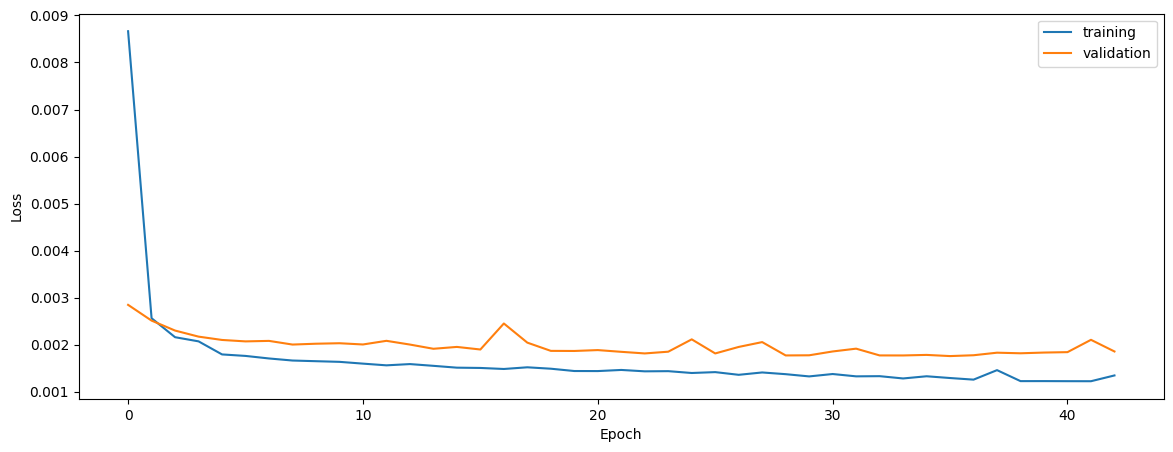

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9477925995146619
0.9380571520153912
0.9263910507989854


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.9422127861447822
0.948650526416305
0.9431987356921256


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.9457348246035625
0.951586207887738
0.9510737471894183


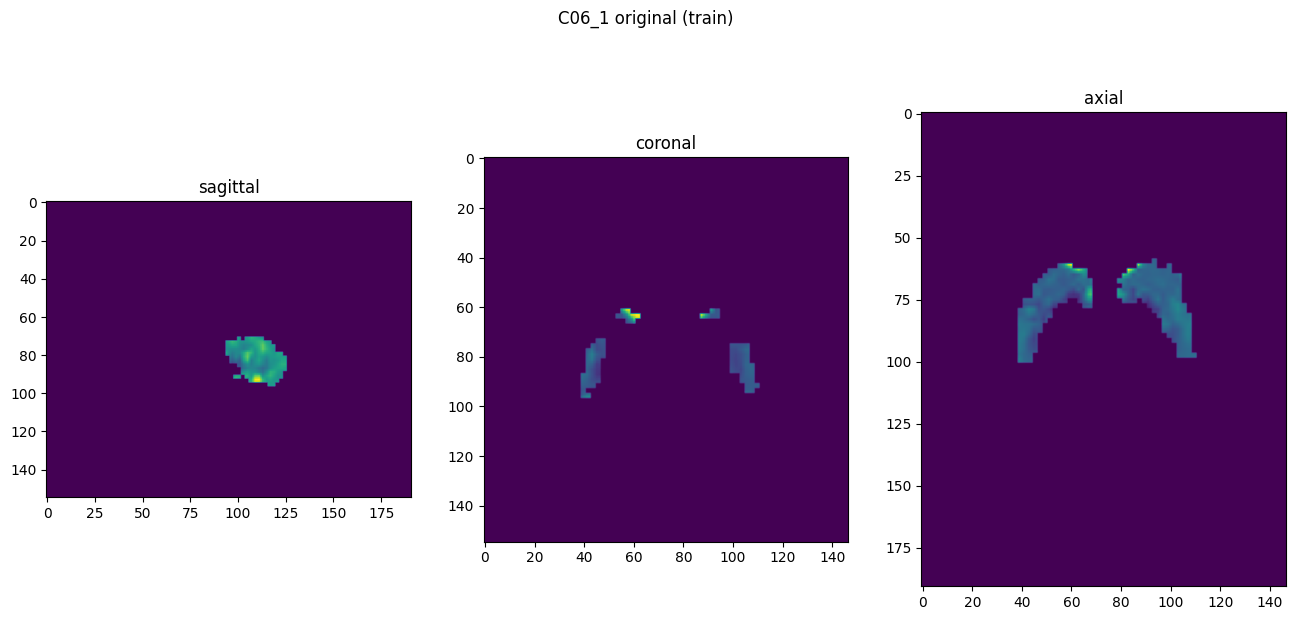

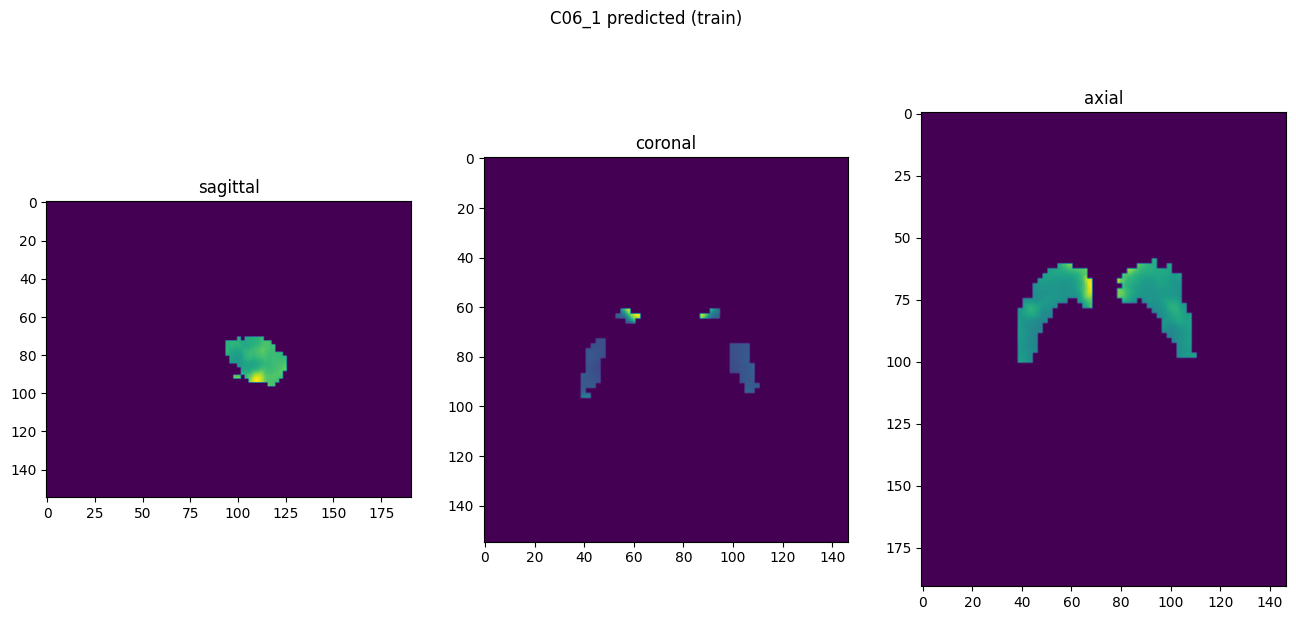

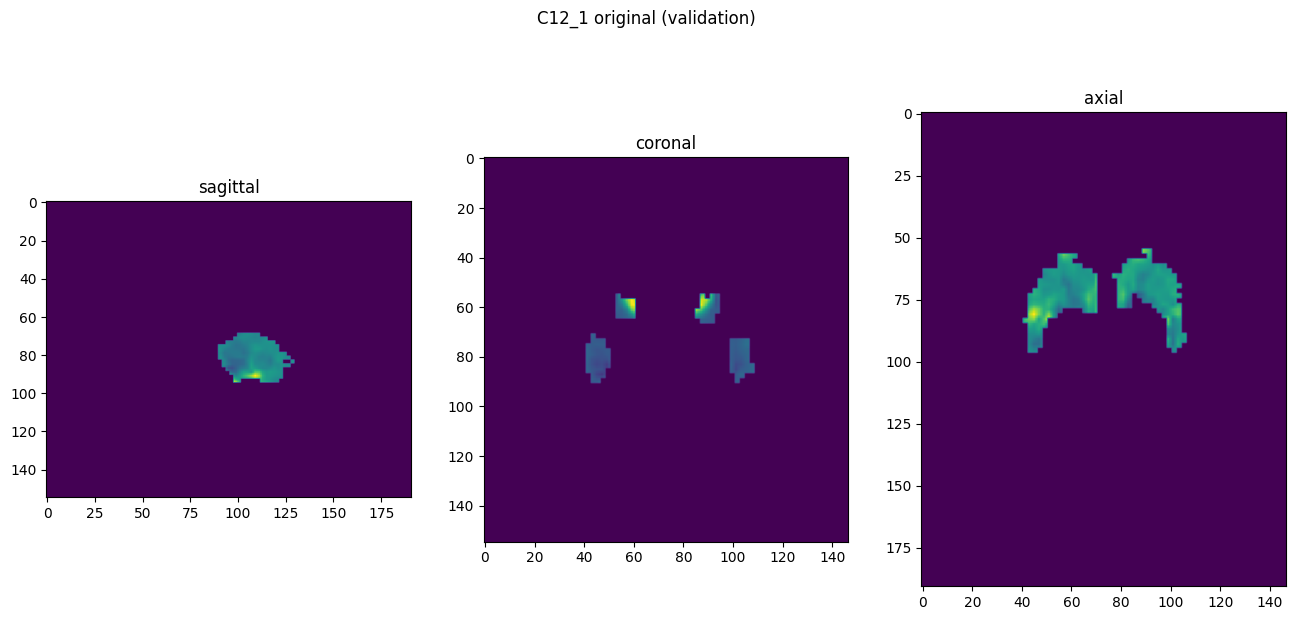

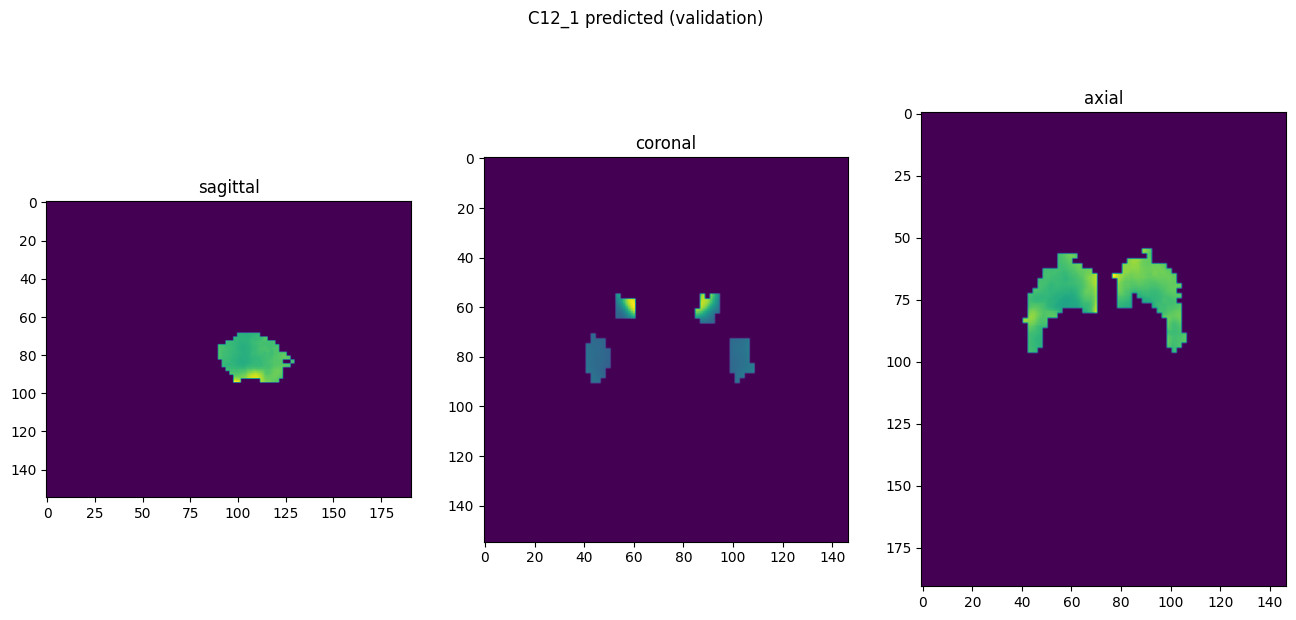

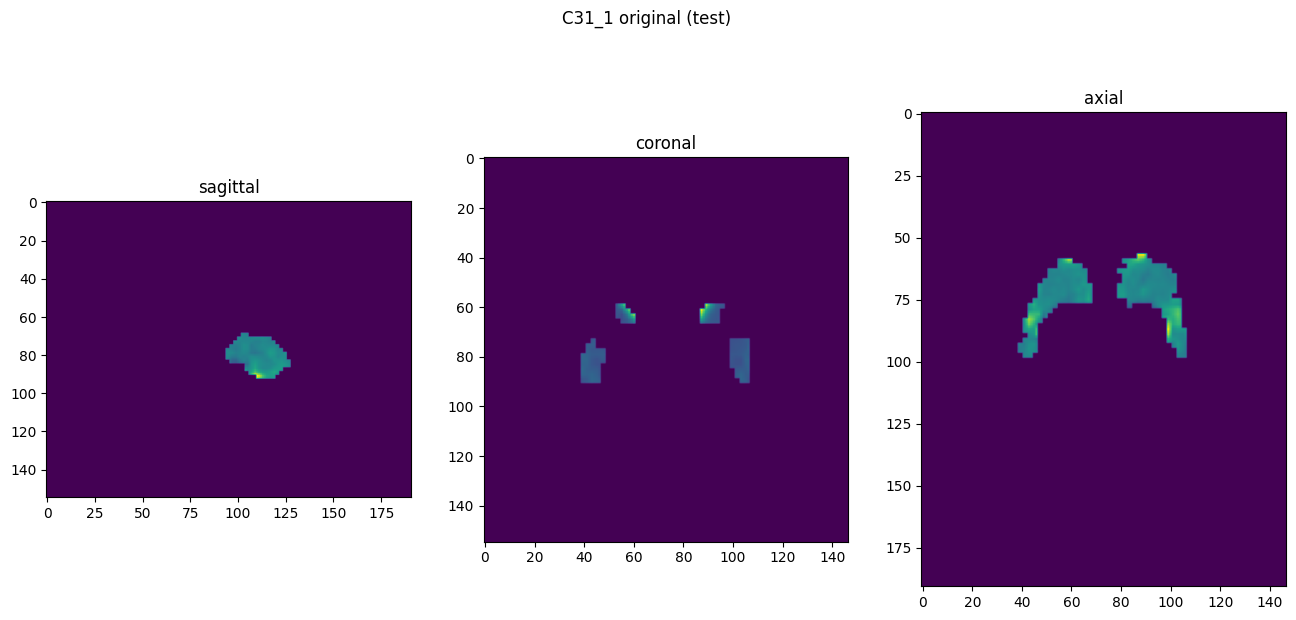

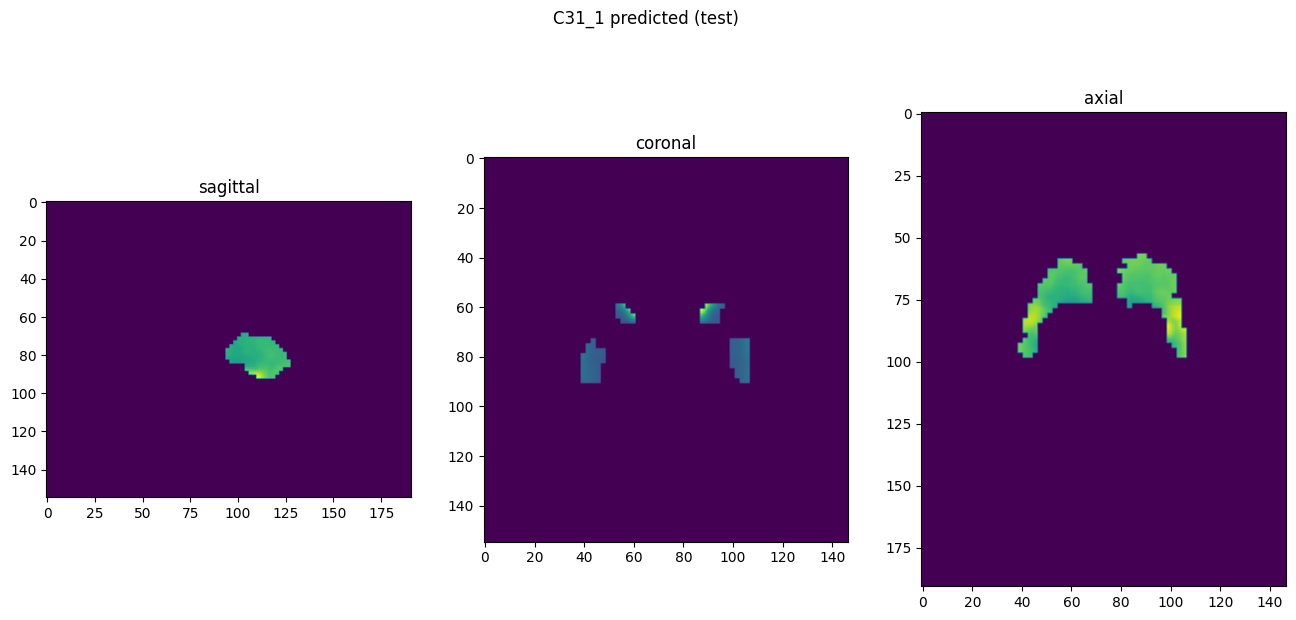

In [10]:
showResults(model, gen, threshold=None, background=False)